In [2]:
import numpy as np
from random import randint
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import corner
import json

import pytensor
from pytensor import tensor as pt
from pytensor.graph.basic import Apply

from pytensor.graph import Apply, Op
from pytensor.tensor.type import TensorType

import jax
from jax import grad, jit, vmap, value_and_grad, random
import jax.numpy as jnp

import pyhf
pyhf.set_backend('jax')
# pyhf.set_backend('numpy')

import pymc as pm
import arviz as az

from pyhf_pymc import prepare_inference
from pyhf_pymc import context_inference
from pyhf_pymc import one_line_inference
from pyhf_pymc import make_op

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import logging
logger = logging.getLogger('pymc')
logger.setLevel(logging.ERROR)

In [3]:
# blue = '#6495ed'
# orange = '#B47D49'

# blue = '#006994'
# orange = '#80396A'
#1F449C
blue = '#1F449C'
orange = '#E57A77'

green = '#006400'
lila = '#C875C4'

plt.rc('font', size=18)      
plt.rc('axes', titlesize=18)   
plt.rc('axes', labelsize=18)   
plt.rc('xtick', labelsize=18)   
plt.rc('ytick', labelsize=18)    
plt.rc('legend', fontsize=15)    
plt.rc('figure', titlesize=18)

plt.rcParams['font.family'] = 'DejaVu Sans'

## Model

In [4]:
nBins = 3
model = pyhf.simplemodels.correlated_background([10]*nBins,[50]*nBins,[55]*nBins,[45]*nBins)

unconstr_dict = {
    'mu': {'type': 'unconstrained', 'input': [[5.], [1.]]}
}

obs = model.expected_actualdata([0., 2.])

prior_dict = prepare_inference.prepare_priors(model, unconstr_dict)
prepared_model = prepare_inference.prepare_model(model=model, observations=obs, priors=prior_dict)

In [5]:
expData_op = make_op.make_op(model)

In [4]:
obs

Array([70., 70., 70.], dtype=float64)

## Prior / Posterior Predictives

In [18]:

# with open('SRee_SRmm_Srem.json') as serialized:
with open('ttbar_ljets_xsec_inclusive_pruned.json') as serialized:
    spec = json.load(serialized)

workspace = pyhf.Workspace(spec)
model = workspace.model()

obs = workspace.data(model, include_auxdata=False)

nBins = len(model.expected_actualdata(model.config.suggested_init()))
nPars = len(model.config.suggested_init())

# Prepare the priors for sampling
    # Unconstrained parameters
unconstr_dict = {
    'uncon1': {'type': 'unconstrained', 'type2': 'normal', 'input': [[2], [1]]}
    }

    # Create dictionary with all priors (unconstrained, constrained by normal and poisson)
prior_dict = prepare_inference.prepare_priors(model, unconstr_dict)

    # dictionary with keys 'model', 'obs', 'priors', 'precision'
prepared_model = prepare_inference.prepare_model(model=model, observations=obs, priors=prior_dict)

In [27]:
with context_inference.pyhf_model(prepared_model):
    step = pm.Metropolis()
    post_data = pm.sample(draws=100, chains = 1, step=step)
    post_pred = pm.sample_posterior_predictive(post_data)
    prior_pred = pm.sample_prior_predictive(100)



Only 100 samples in chain.


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 0 seconds.


Sampling: [Expected_Data, Normals, Unconstrained]


In [28]:
mean0 = prior_pred.prior_predictive.Expected_Data[0].T[0].mean()
mean1 = prior_pred.prior_predictive.Expected_Data[0].T[1].mean()
mean2 = prior_pred.prior_predictive.Expected_Data[0].T[2].mean()

post_mean0 = post_pred.posterior_predictive.Expected_Data[0].T[0].mean()
post_mean1 = post_pred.posterior_predictive.Expected_Data[0].T[1].mean()
post_mean2 = post_pred.posterior_predictive.Expected_Data[0].T[2].mean()

Text(0, 0.5, 'Events')

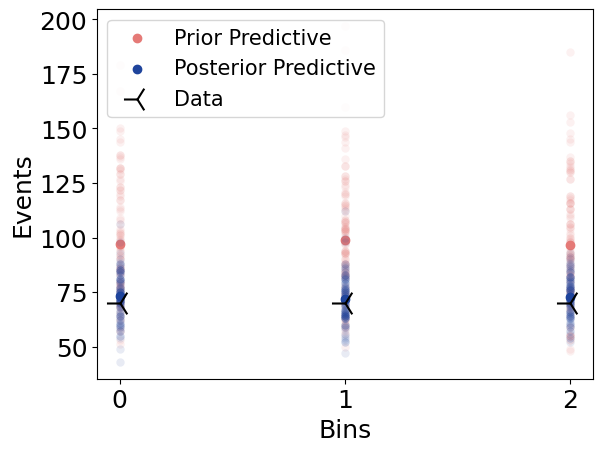

In [34]:
plt.scatter(np.linspace(0,nBins-1,nBins), [mean0, mean1, mean2], color=orange, label='Prior Predictive')

plt.scatter(np.full(len(prior_pred.prior_predictive.Expected_Data[0].T[0]), 0), prior_pred.prior_predictive.Expected_Data[0].T[0], alpha=0.1, color=orange, linewidths=0)
plt.scatter(np.full(len(prior_pred.prior_predictive.Expected_Data[0].T[0]), 1), prior_pred.prior_predictive.Expected_Data[0].T[1], alpha=0.1, color=orange, linewidths=0)
plt.scatter(np.full(len(prior_pred.prior_predictive.Expected_Data[0].T[0]), 2), prior_pred.prior_predictive.Expected_Data[0].T[2], alpha=0.1, color=orange, linewidths=0)


plt.scatter(np.linspace(0,nBins-1,nBins), [post_mean0, post_mean1, post_mean2], color=blue, label='Posterior Predictive')

plt.scatter(np.full(len(prior_pred.prior_predictive.Expected_Data[0].T[0]), 0), post_pred.posterior_predictive.Expected_Data[0].T[0], alpha=0.1, color=blue, linewidths=0)
plt.scatter(np.full(len(prior_pred.prior_predictive.Expected_Data[0].T[0]), 1), post_pred.posterior_predictive.Expected_Data[0].T[1], alpha=0.1, color=blue, linewidths=0)
plt.scatter(np.full(len(prior_pred.prior_predictive.Expected_Data[0].T[0]), 2), post_pred.posterior_predictive.Expected_Data[0].T[2], alpha=0.1, color=blue, linewidths=0)

# Observations
plt.scatter(np.arange(nBins), obs, marker='3', c = 'k',s=380, zorder = 999, label = "Data")
plt.legend(loc='upper left')

plt.xticks([0, 1, 2])
plt.xlabel('Bins')
plt.ylabel('Events')

# plt.savefig('final_plots/prior_posterior_events.pdf')


In [ ]:
# Prior
plt.step(np.linspace(0,nBins-1,nBins),prior_pred.prior_predictive.Expected_Data[0].T, alpha = 0.035, c = orange, where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(prior_pred.prior_predictive.Expected_Data[0],[.15,.85],axis=0), colors = orange , label='Prior Predictive');

# Posterior
plt.step(np.linspace(0,nBins-1,nBins),post_pred.posterior_predictive.Expected_Data[0].T, alpha = 0.035, c = blue, where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(post_pred.posterior_predictive.Expected_Data[0],[.15,.85],axis=0), colors = blue, label='Posterior Predictive')

# Observations
plt.scatter(np.arange(nBins), obs, c = 'k',s=24, zorder = 999, label = "Data")
plt.legend(loc='upper left')
# plt.margins(x=0.015)

plt.title(f'Prior and Posterior Predictive ')
plt.xticks([0, 1, 2])
plt.xlabel('Bins')
plt.ylabel('Events')


plt.show()

## Corner Plots Prior / Posterior

In [ ]:
with context_inference.pyhf_model(prepared_model):
    step = pm.Metropolis()
    post_data = pm.sample(10_000, chains = 1, step=step)
    post_pred = pm.sample_posterior_predictive(post_data)
    prior_pred = pm.sample_prior_predictive(10_000)

Sampling 1 chain for 1_000 tune and 10_000 draw iterations (1_000 + 10_000 draws total) took 1 seconds.


Sampling: [Expected_Data, Normals, Unconstrained]


In [ ]:
my_range = [(-5, 5), (0, 16)]
my_bins = [25, 25]

a = corner.corner(prior_pred.prior, quantiles=[0.5], show_titles=True, title_fmt=None, color=orange, labels=['', ''], bins=my_bins, range=my_range)
corner.corner(post_data.posterior, quantiles=[0.5], color = blue, truths=[0., 2.], truth_color='grey', bins=[25, 25], fig=a, labels=['Correlated background', 'Signal strength'], range=my_range)
a.suptitle('Prior and Posterior Parameter Distributions')


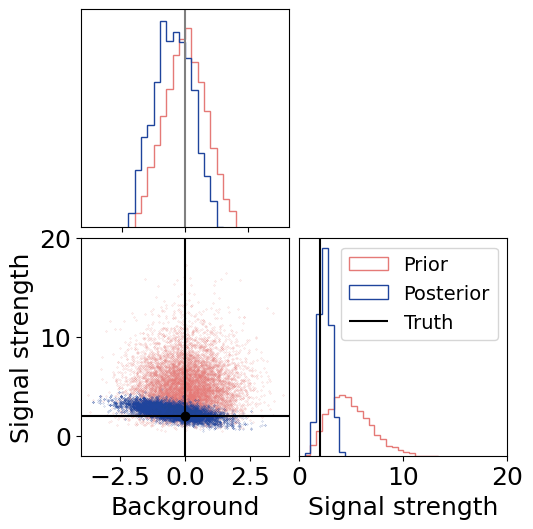

In [ ]:
yrange = (0, 13_000)

fig, axs = plt.subplots(2, 2, figsize=(5.5, 5.8))
plt.subplots_adjust(wspace=0.05, hspace=0.05)
# fig.suptitle('Prior and Posterior Parameter Distributions')
axs[0, 1].remove()

ax1 = axs[0, 0]
ax2 = axs[1, 0]
ax3 = axs[1, 1]

# Normals Histogram
ax1.hist(prior_pred.prior.Normals[0], bins=30, histtype='step', color=orange)
_, bins, _ = ax1.hist(prior_pred.prior.Normals[0], bins=30, histtype='step', color=orange, alpha=0.000001)
ax1.hist(post_data.posterior.Normals[0], bins=bins, histtype='step', color=blue)
ax1.set_ylim(130)
ax1.vlines(0, 0, 13_000, color='grey')
ax1.set_yticks([])


# Scatter Plot
ax2.scatter(prior_pred.prior.Normals[0], prior_pred.prior.Unconstrained[0], alpha=0.6, s=0.04, color=orange)
ax2.scatter(post_data.posterior.Normals[0], post_data.posterior.Unconstrained[0], alpha=0.6, s=0.04, color=blue)
ax2.vlines(0, -2, 30, color='black')
ax2.set_ylim(-2, 20)
ax2.hlines(2, -6, 6, color='black')
ax2.set_xlim(-4, 4)
ax2.scatter(0, 2, color='black')
ax2.set_xlabel('Background')
ax2.set_ylabel('Signal strength')

# Unconstrained Histogram
ax3.hist(prior_pred.prior.Unconstrained[0], bins=30, histtype='step', color=orange, label='Prior')
_, bins, _ = ax3.hist(prior_pred.prior.Unconstrained[0], bins=30, histtype='step', color=orange, alpha=0.000001)
ax3.hist(post_data.posterior.Unconstrained[0], bins=bins, histtype='step', color=blue, label='Posterior')
ax3.set_yticks([])
ax3.set_xticks([0, 10, 20])
ax3.set_ylim(30)
ax3.set_xlim(0)
ax3.vlines(2, 0, 13_000, color='black', label='Truth')
ax3.set_xlabel('Signal strength')
plt.rc('legend', fontsize=14)  
ax3.legend()

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

  

## Calibration 1

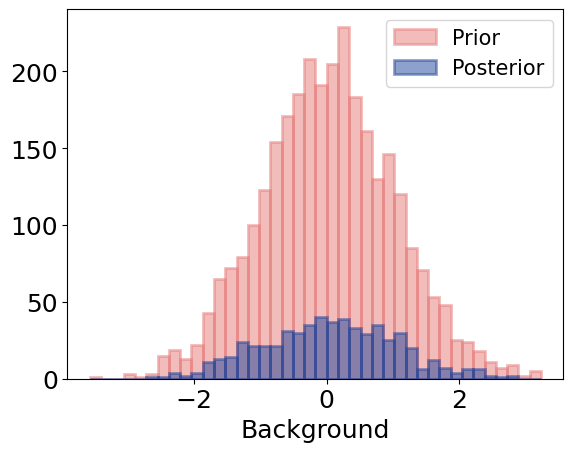

In [14]:
plt.hist(prior_Normals, 40, alpha = 0.5, color=orange, linewidth=2, label='Prior', edgecolor=orange)
_, bins, _ = plt.hist(prior_Normals, bins=40, histtype='step', color=orange, alpha=0.000001)
plt.hist(post_Normals, bins=bins, alpha = 0.5, color=blue, linewidth=2, label='Posterior', edgecolor=blue)
plt.xlabel('Background')

plt.legend()

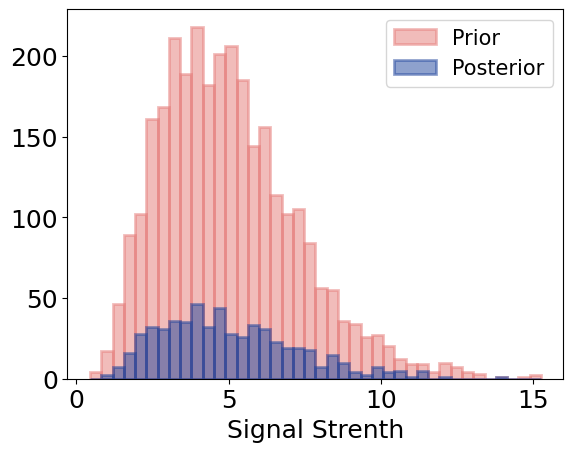

In [15]:
plt.hist(prior_Unconstrained, 40, alpha = 0.5, color=orange, linewidth=2, label='Prior', edgecolor=orange)
_, bins, _ = plt.hist(prior_Unconstrained, bins=40, histtype='step', color=orange, alpha=0.000001)
plt.hist(post_Unconstrained, bins=bins, alpha = 0.5, color=blue, linewidth=2, label='Posterior', edgecolor=blue)
plt.xlabel('Signal Strenth')

plt.legend()

## Calibration 2

In [5]:
from pyhf_pymc import plotting

In [6]:
with context_inference.pyhf_model(prepared_model):
    step = pm.Metropolis()
    prior_pred = pm.sample_prior_predictive(60)

prior_Normals, prior_Unconstrained, prior_data = np.concatenate(prior_pred.prior.Normals[0]), np.concatenate(prior_pred.prior.Unconstrained[0]), np.array(prior_pred.prior_predictive.Expected_Data[0])

Sampling: [Expected_Data, Normals, Unconstrained]


In [ ]:
post_Normals, post_Unconstrained, post_data = plotting.calibration(prepared_model, prior_pred)

In [16]:
import pandas as pd

In [63]:
post_Unconstrained = np.asarray(pd.read_csv('post_Unconstrained_Metropolis.txt', header=None))[0].tolist()
post_Unconstrained.remove(' ')
post_Normals = np.asarray(pd.read_csv('post_Normals_Metropolis.txt', header=None))[0].tolist()
post_Normals.remove(' ')

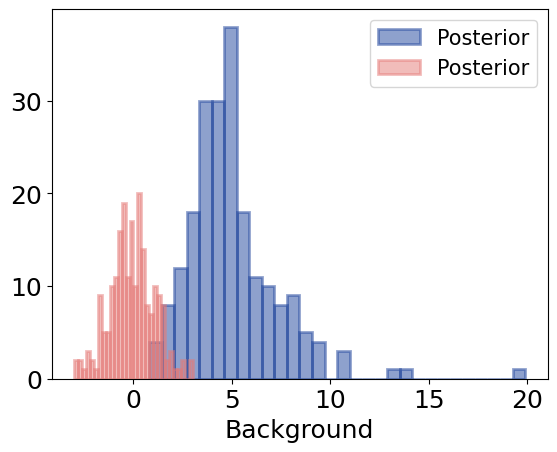

In [69]:
# plt.hist(prior_Normals, 40, alpha = 0.5, color=orange, linewidth=2, label='Prior', edgecolor=orange)
# _, bins, _ = plt.hist(prior_Normals, bins=40, histtype='step', color=orange, alpha=0.000001)
plt.hist(post_Unconstrained, bins=30, alpha = 0.5, color=blue, linewidth=2, label='Posterior', edgecolor=blue)
plt.hist(post_Normals, bins=30, alpha = 0.5, color=orange, linewidth=2, label='Posterior', edgecolor=orange)
plt.xlabel('Background')

plt.legend()

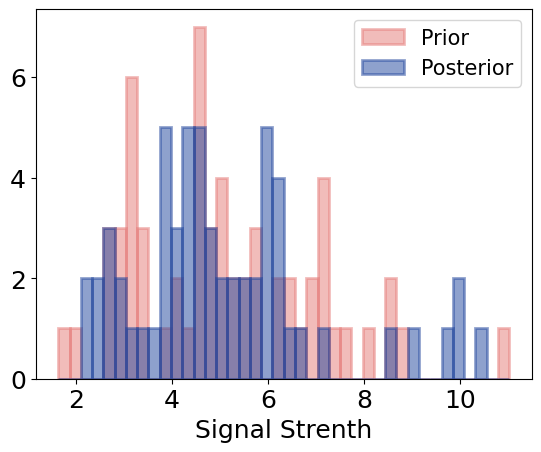

In [10]:
plt.hist(prior_Unconstrained, 40, alpha = 0.5, color=orange, linewidth=2, label='Prior', edgecolor=orange)
_, bins, _ = plt.hist(prior_Unconstrained, bins=40, histtype='step', color=orange, alpha=0.000001)
plt.hist(post_Unconstrained, bins=bins, alpha = 0.5, color=blue, linewidth=2, label='Posterior', edgecolor=blue)
plt.xlabel('Signal Strenth')

plt.legend()

In [21]:
np.array(post_Normals).mean()

-0.032289264691391574

## Calibration 3

In [11]:
with context_inference.pyhf_model(prepared_model):
    step = pm.Metropolis()
    prior_pred = pm.sample_prior_predictive(10)

prior_Normals, prior_Unconstrained, prior_data = np.concatenate(prior_pred.prior.Normals[0]), np.concatenate(prior_pred.prior.Unconstrained[0]), np.array(prior_pred.prior_predictive.Expected_Data[0])

Sampling: [Expected_Data, Normals, Unconstrained]


In [12]:
with open('prior_Normals_Metropolis.txt', 'w') as filehandle:
    json.dump(prior_Normals.tolist(), filehandle)
with open('prior_Unconstrained_Metropolis.txt', 'w') as filehandle:
    json.dump(prior_Unconstrained.tolist(), filehandle)

In [15]:
def posterior_from_prior(prior_data):
        with pm.Model() as m:
                pars = prepare_inference.priors2pymc(prepared_model)
                Expected_Data = pm.Poisson("Expected_Data", mu=expData_op(pars), observed=prior_data)
                
                step1 = pm.Metropolis()
                post_data = pm.sample(1, chains=1, step=step1, tune=1000)
                post_pred = pm.sample_posterior_predictive(post_data)

        return np.concatenate(post_data.posterior.Normals[0]), np.concatenate(post_data.posterior.Unconstrained[0]), np.array(post_pred.posterior_predictive.Expected_Data[0][0])

In [ ]:
post_Normals, post_Unconstrained, post_data = [], [], []
i = 0
for p_d in prior_data:
    a, b, c = posterior_from_prior(p_d)
    post_Normals.append(a[0])
    post_Unconstrained.append(b[0])
    post_data.append(c[0])

    with open('post_Normals_Metropolis.txt', 'a') as file:
        file.write(f'{post_Normals[i]}, ')

    with open('post_Unconstrained_Metropolis.txt', 'a') as file:
        file.write(f'{post_Unconstrained[i]}, ')

    print(f'STEP: {i}')
    i += 1

## Autocorrelation

In [22]:
with context_inference.pyhf_model(prepared_model):
    step = pm.Metropolis()
    post_data_MH = pm.sample(100, chains = 1, step=step)

with context_inference.pyhf_model(prepared_model):
    step = pm.Metropolis()
    post_data_MH_thinned = pm.sample(1200, chains = 1, step=step)

Only 100 samples in chain.


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 0 seconds.
/Users/malinhorstmann/anaconda3/envs/pyhf_pymc/lib/python3.9/site-packages/arviz/data/base.py:221: UserWarning: More chains (100) than draws (2). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


Sampling 1 chain for 1_000 tune and 1_200 draw iterations (1_000 + 1_200 draws total) took 0 seconds.
/Users/malinhorstmann/anaconda3/envs/pyhf_pymc/lib/python3.9/site-packages/arviz/data/base.py:221: UserWarning: More chains (1200) than draws (2). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


In [23]:
with context_inference.pyhf_model(prepared_model):
    post_data_NUTS = pm.sample(100, chains = 1)

with context_inference.pyhf_model(prepared_model):
    post_data_NUTS_thinned = pm.sample(600, chains = 1)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 1 seconds.
/Users/malinhorstmann/anaconda3/envs/pyhf_pymc/lib/python3.9/site-packages/arviz/data/base.py:221: UserWarning: More chains (100) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Sampling 1 chain for 1_000 tune and 600 draw iterations (1_000 + 600 draws total) took 1 seconds.
/Users/malinhorstmann/anaconda3/envs/pyhf_pymc/lib/python3.9/site-packages/arviz/data/base.py:221: UserWarning: More chains (600) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


In [24]:
thinned_MH = post_data_MH_thinned.posterior.thin(12)
thinned_NUTS = post_data_NUTS_thinned.posterior.thin(6)

In [25]:
# Metropolis
post_Normals_MH = np.concatenate(np.array(post_data_MH.posterior.Normals[0]))
post_Unconstrained_MH = np.concatenate(np.array(post_data_MH.posterior.Unconstrained[0]))

post_Normals_MH_thinned = np.concatenate(np.array(thinned_MH.Normals[0]))
post_Unconstrained_MH_thinned = np.concatenate(np.array(thinned_MH.Unconstrained[0]))

# NUTS
post_Normals_NUTS = np.concatenate(np.array(post_data_NUTS.posterior.Normals[0]))
post_Unconstrained_NUTS = np.concatenate(np.array(post_data_NUTS.posterior.Unconstrained[0]))

post_Normals_NUTS_thinned = np.concatenate(np.array(thinned_NUTS.Normals[0]))
post_Unconstrained_NUTS_thinned = np.concatenate(np.array(thinned_NUTS.Unconstrained[0]))

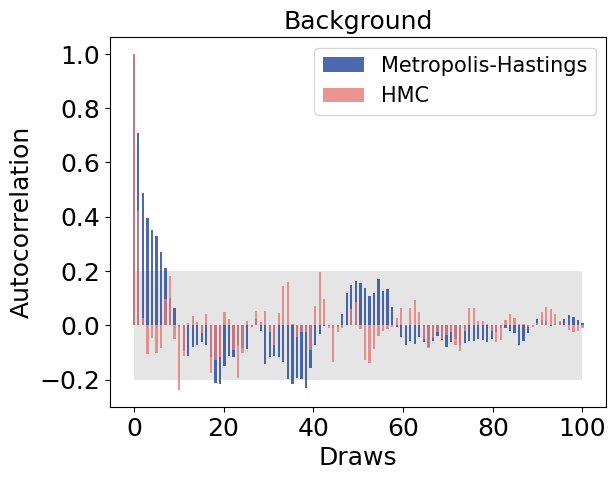

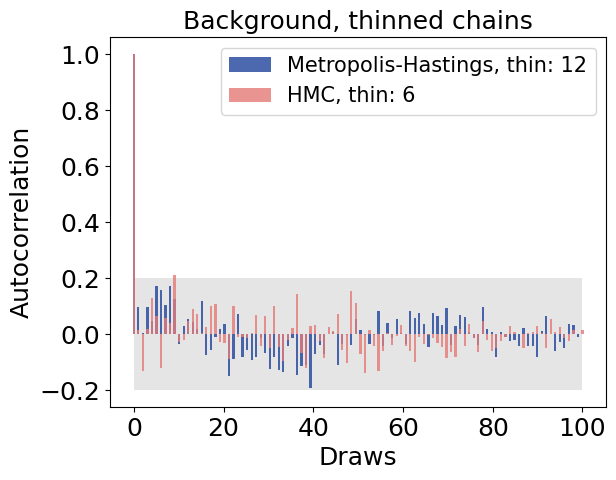

In [26]:
fig = plt.bar(np.linspace(0, 100, 100), az.autocorr(post_Normals_MH), width=0.5, alpha=0.8, color=blue, label='Metropolis-Hastings')
plt.bar(np.linspace(0, 100, 100), az.autocorr(post_Normals_NUTS), width=0.5, alpha=0.8, color=orange, label='HMC')
plt.fill_between(np.linspace(0, 100, 100), -0.2, 0.2, color='grey', alpha=0.2, zorder=0, linewidth=0)
plt.xlabel('Draws')
plt.ylabel('Autocorrelation')
plt.legend()
plt.title('Background')
plt.show()


plt.bar(np.linspace(0, 100, 100), az.autocorr(post_Normals_MH_thinned), width=0.5, alpha=0.8, color=blue, label='Metropolis-Hastings, thin: 12')
plt.bar(np.linspace(0, 100, 100), az.autocorr(post_Normals_NUTS_thinned), width=0.5, alpha=0.8, color=orange, label='HMC, thin: 6')
plt.fill_between(np.linspace(0, 100, 100), -0.2, 0.2, color='grey', alpha=0.2, zorder=0, linewidth=0)
plt.xlabel('Draws')
plt.ylabel('Autocorrelation')
plt.legend()
plt.title('Background, thinned chains');

In [ ]:
plt.bar(np.linspace(0, 100, 100), az.autocorr(post_Unconstrained_MH), width=0.5, alpha=0.8, color=green, label='Metropolis-Hastings')
plt.bar(np.linspace(0, 100, 100), az.autocorr(post_Unconstrained_NUTS), width=0.5, alpha=0.8, color=lila, label='HMC (NUTS)')
plt.fill_between(np.linspace(0, 100, 100), -0.2, 0.2, color='grey', alpha=0.2, zorder=0, linewidth=0)
plt.legend()
plt.title('Autocorrelation for the signal strength')
plt.show()


plt.bar(np.linspace(0, 100, 100), az.autocorr(post_Unconstrained_MH_thinned), width=0.5, alpha=0.8, color=green, label='Metropolis-Hastings, thin: 12')
plt.bar(np.linspace(0, 100, 100), az.autocorr(post_Unconstrained_NUTS_thinned), width=0.5, alpha=0.8, color=lila, label='HMC (NUTS), thin: 6')
plt.fill_between(np.linspace(0, 100, 100), -0.2, 0.2, color='grey', alpha=0.2, zorder=0, linewidth=0)
plt.legend()
plt.title('Autocorrelation for the signal strength, thinned chains')